# **Probing Tasks - How Does BERT Answer Questions?**
In this notebook, we will carry out the following badges:

**0.** implement the `jiant`'s pipeline: 

**1.**   reproduce the probing tasks: (with bert-base and bert-finetuned)
  *   NEL, REL, COREF on the Ontonotes dataset
  *   QUES on TREC-10 dataset
  *   SUP on the Squad dataset
  *   SUP on the Babi dataset
  *   ~~SUP on the Hotpot dataset~~: *We don't do this probing task because for this task we need to train bert-large. It might take very long time to train.*

**2.**   experiment with BERT base uncased trained on Adversarial dataset

**3.**   experiment with Roberta-base model on a task



# **0. Implement `jiant's` pipeline**

---



`jiant` has a new training pipeline to facilitate modern experimental workflows (see report). For further use, we implement a convenient method to complete the whole pipeline and to train the model on probing task.

## **0.1 Use modified `jiant` library**
We modified some codes of the [original jiant library](https://github.com/nyu-mll/jiant) in order to achieve our desired functions that aren't supported by `jiant` e.g probing each layer. For more details please see our pdf report.

First, we will clone the modified jiant and install libraries we need for this code.

In [1]:
!git clone https://github.com/SwiftPredator/How-Does-Bert-Answer-QA-DLP2021.git

# copy the modified jiant lib to the /content/
!mv "/content/How-Does-Bert-Answer-QA-DLP2021/src/probing-tasks/jiant" "/content/"

%cd jiant
!pip install -r requirements-no-torch.txt
!pip install --no-deps -e ./
!pip install gdown  # lib to download file from googlde drive link

Cloning into 'How-Does-Bert-Answer-QA-DLP2021'...
remote: Enumerating objects: 1494, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1494 (delta 66), reused 78 (delta 33), pack-reused 1364
Receiving objects: 100% (1494/1494), 164.54 MiB | 19.26 MiB/s, done.
Resolving deltas: 100% (731/731), done.
Checking out files: 100% (467/467), done.
/content/jiant
     |████████████████████████████████| 255 kB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 8.3 MB/s 
     |████████████████████████████████| 147 kB 51.3 MB/s 
     |████████████████████████████████| 1.5 MB 50.1 MB/s 
     |████████████████████████████████| 162 kB 48.0 MB/s 
     |████████████████████████████████| 20.2 MB 1.9 MB/s 
     |████████████████████████████████| 10.0 MB 47.2 MB/s 
     |████████████████████████████████| 48 kB 4.3 MB/s 
     |████████████████████████████████| 883 kB 35.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.8 MB/s 

Obtaining file:///content/jiant
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Running setup.py develop for jiant


Restart runtime after installing libs

## **0.2 Download Edge Probing data**
After preprocessing and generating the Edge Probing data for all the tasks (see report for details), these data was uploaded to our github and will be used here. Next, we will create the corresponding task configs.

Because the tasks QUES and SUP are not supported by jiant, we added new task QUES to the jiant library (see report). The task SUP has the same jiant format structure as COREF, therefore we will reuse the default COREF task in jiant to probe SUP task.

In [2]:
%cd /content/jiant

import jiant.utils.python.io as py_io
import jiant.utils.display as display
import os

def init_task_config(task_name, size):
  jiant_task = task_name
  if(task_name == "sup-squad" or task_name == "sup-babi"):
    jiant_task = "coref"  # use coref task to probe supporting facts task because of the analog structure of jiant EP json format

  os.makedirs("/content/tasks/configs/", exist_ok=True)
  os.makedirs(f"/content/tasks/data/{task_name}", exist_ok=True)

  py_io.write_json({
    "task": jiant_task,
    "paths": {
      "train": f"/content/tasks/data/{task_name}/{size}/train.jsonl",
      "val":   f"/content/tasks/data/{task_name}/{size}/val.jsonl",
    },
    "name": jiant_task
  }, f"/content/tasks/configs/{task_name}_config.json")

/content/jiant


In [3]:
task_names = [
              #"ner", 
              #"semeval", 
              "coref",    
              #"ques" 
              #"sup-squad", 
              #"sup-babi",
              #"sup-hotpot",
             ]

size = "test" # small, medium or big

for task_name in task_names:
  init_task_config(task_name, size)

In [4]:
# copy the task data to the tasks folder created above
!cp -r "/content/How-Does-Bert-Answer-QA-DLP2021/src/probing-tasks/data" "/content/tasks"

## **0.3 Download BERT models**
Next, we download the models we want to train, for example a `bert-base-uncased` and a `bert-base-uncased-squad-v1` model



In [5]:
import jiant.proj.main.export_model as export_model

models = [
          "bert-base-uncased", 
          "csarron/bert-base-uncased-squad-v1"
          ]

for model in models:
  export_model.export_model(
      hf_pretrained_model_name_or_path=model,
      output_base_path=f"/content/models/{model}",
  )

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of the model checkpoint at csarron/bert-base-uncased-squad-v1 were not used when initializing BertForPreTraining: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForPreTraining were not initialized from the model checkpoint at csarron/bert-base-uncased-squad-v1 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.

## **0.4 Tokenize and cache**
With the model and data ready, we can now tokenize and cache the inputs features for our task. This converts the input examples to tokenized features ready to be consumed by the model, and saved them to disk in chunks.

In [6]:
import jiant.shared.caching as caching
import jiant.proj.main.tokenize_and_cache as tokenize_and_cache

seq_length_options = {
    "ner":        128, 
    "semeval":    128, 
    "coref":      128,
    "ques":       128,     
    "sup-squad":  384, 
    "sup-babi":   384,
    "sup-hotpot": 384,
}

# Tokenize and cache each task
def tokenize(task_name, model):
    tokenize_and_cache.main(tokenize_and_cache.RunConfiguration(
        task_config_path=f"/content/tasks/configs/{task_name}_config.json",
        hf_pretrained_model_name_or_path=model,
        output_dir=f"/content/cache/{task_name}",
        phases=["train", "val"],
        max_seq_length=seq_length_options[task_name],
    ))

for task_name in task_names:
  for model in models:
    tokenize(task_name, model)

CorefTask
  [train]: /content/tasks/data/coref/test/train.jsonl
  [val]: /content/tasks/data/coref/test/val.jsonl



CorefTask
  [train]: /content/tasks/data/coref/test/train.jsonl
  [val]: /content/tasks/data/coref/test/val.jsonl


We can inspect the first examples of the first chunk of each task.

In [7]:
row = caching.ChunkedFilesDataCache(f"/content/cache/{task_names[0]}/train").load_chunk(0)[0]["data_row"]
print(row.input_ids)
print(row.tokens)
print(row.spans)
print(row.tokens[row.spans[0][0]: row.spans[0][1]+1])
#print(row.tokens[row.spans[1][0]: row.spans[1][1]+1])

[  101 24111  1005  1055  2197  2420  1998  2054  2003  2056  2002  2001
  2066   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
['[CLS]', 'saddam', "'", 's', 'last', 'days', 'and', 'what', 'is', 'said', 'he', 'was', 'like', '[SEP]']
[[ 1  3]
 [10 10]]
['saddam', "'", 's']


## **0.5 Write a run config**
Here we are going to write what we call a `jiant_task_config`. This configuration file basically defines a lot of the subtleties of our training pipeline, such as what tasks we will train on, do evaluation on, batch size for each task. We use a helper `Configurator` to write out a `jiant_task_container_config`.

In [8]:
import jiant.proj.main.scripts.configurator as configurator

def create_jiant_task_config(task_name):
  jiant_run_config = configurator.SimpleAPIMultiTaskConfigurator(
      task_config_base_path="/content/tasks/configs",
      task_cache_base_path="/content/cache",
      train_task_name_list=[task_name],
      val_task_name_list=[task_name],
      train_batch_size=16,
      eval_batch_size=32,
      epochs=5,
      num_gpus=1,
  ).create_config()
  os.makedirs("/content/tasks/run_configs/", exist_ok=True)
  py_io.write_json(jiant_run_config, f"/content/tasks/run_configs/{task_name}_run_config.json")
  #display.show_json(jiant_run_config)

## **0.6 Write the training function**
The last step is to train the model on the probing tasks. We create a function that allows us to configure the training process through the parameters e.g which probing task, which model and number of layers you want to train.

In [9]:
import jiant.proj.main.runscript as main_runscript

def run_probing_task(task_name, model_name="bert-base-uncased", num_layers=1, bin_model_path=""):
  hf_model_name = model_name
  if(model_name == "bert-babi"):
    hf_model_name = "bert-base-uncased"
  
  run_args = main_runscript.RunConfiguration(
      jiant_task_container_config_path=f"/content/tasks/run_configs/{task_name}_run_config.json",
      output_dir=f"/content/tasks/runs/{task_name}",
      hf_pretrained_model_name_or_path=hf_model_name,
      model_path=f"/content/models/{model_name}/model/model.p",
      model_config_path=f"/content/models/{model_name}/model/config.json",
      learning_rate=1e-2,
      eval_every_steps=1000,
      do_train=True,
      do_val=True,
      do_save=True,
      force_overwrite=True,
      num_hidden_layers=num_layers,
      bin_model_path=bin_model_path,
  )
  return main_runscript.run_loop(run_args)

We sum up all the steps above in a convenient method that do the whole probing pipeline. After probing we extract the macro averaged F1 to prepare for the visualization.

In [10]:
# the whole jiant pipeline
def probe(model, task_name, n_layers, dataset_size):
  init_task_config(task_name, dataset_size)
  tokenize(task_name, model)
  create_jiant_task_config(task_name)
  probing_output = run_probing_task(task_name, model, n_layers)
  f1_macro = str(probing_output[task_name]["metrics"]["minor"]["f1_macro"])
  
  return f1_macro

## **0.7 Write the visualization**


In [176]:
import os
import json
import matplotlib.pyplot as plt

num_layers = list(range(1, 13, 2))      # from 1 to 12 layers

def plot_task(model, task, linestyle, f1_result):
  y = [float(f1_result[model][task][n_layers]['f1_macro']) for n_layers in num_layers]
  plt.plot(num_layers, y,linestyle, label=model)
  plt.grid(True)
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
  plt.suptitle(task)
  plt.xlim(0, 12)

def plot_task_from_file(input_path, model, task, linestyle, f1_result):
  with open(input_path, "r") as f:
    f1_result = json.load(f)
  y = [float(f1_result[model][task][n_layers]['f1_macro']) for n_layers in num_layers]
  plt.plot(num_layers, y,linestyle, label=model)
  plt.legend()
  plt.suptitle(task)


model_to_linestyle = {
    "bert-base-uncased": ":g", 
    "csarron/bert-base-uncased-squad-v1": "-y",
    "bert-babi": "b",
    "bert-adversarial": "r",
    "roberta-base": "m",
}

# **1. Reproduce the probing tasks**

---



##**1.0 Download and export models**

Now we can start training the models on the probing tasks like the paper did, and then visualize the results.

Download the bert models from huggingface web. Skip this step If these models was already downloaded.

In [ ]:
import jiant.proj.main.export_model as export_model

models = [
          "bert-base-uncased", 
          "csarron/bert-base-uncased-squad-v1"
          ]

for model in models:
  export_model.export_model(
      hf_pretrained_model_name_or_path=model,
      output_base_path=f"/content/models/{model}",
  )

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at csarron/bert-base-uncased-squad-v1 were not used when initializing BertForPreTraining: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForPreTraining were not initialized from the model checkpoint at cs

Download and export bert babi model provided by Betty (https://cloud.beuth-hochschule.de/index.php/s/X8NN6BaZA3Wg7JW)

In [ ]:
babi_id_url = "1nl8Hft8isOmocwjZ-ulAvIfwifAyMTtY"
os.makedirs("/content/babi-bin-betty/", exist_ok=True)
!gdown --id $babi_id_url -O "/content/babi-bin-betty/babi.bin"


babi_model_path = "/content/babi-bin-betty/babi.bin"
model_name = "bert-babi"
export_model.export_model(
    hf_pretrained_model_name_or_path="bert-base-uncased",
    bin_model_path=babi_model_path,
    output_base_path=f"/content/models/{model_name}",
)

Downloading...
From: https://drive.google.com/uc?id=1nl8Hft8isOmocwjZ-ulAvIfwifAyMTtY
To: /content/babi-bin-betty/babi.bin
438MB [00:06, 70.2MB/s]


## **1.1 NER Task**

In [151]:
ner_results = {}
task = "ner"
dataset_size = "small"

bert_base_model = "bert-base-uncased"
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
bert_babi_model = "bert-babi"

### 1.1.1 Train `bert-base` model

In [ ]:
bert_base_model = "bert-base-uncased"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ner_results[bert_base_model] = {}
ner_results[bert_base_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(bert_base_model, task, n_layers, dataset_size) # get f1_macro after probing
    ner_results[bert_base_model][task][n_layers] = {}
    ner_results[bert_base_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [152]:
ner_results[bert_base_model] = {
      'ner': {
          1: {'f1_macro': '0.3268712768712769'}, 
          3: {'f1_macro': '0.3961069023569024'}, 
          5: {'f1_macro': '0.0'}, 
          7: {'f1_macro': '0.0'}, 
          9: {'f1_macro': '0.0'}, 
          11: {'f1_macro': '0.0'}
        }
      }

### 1.1.2 Train `bert-base-finetuned-squad` model

In [ ]:
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
num_layers = list(range(7, 13, 2))      # from 1 to 12 layers 

ner_results[bert_squad_model] = {}
ner_results[bert_squad_model][task] = {}
for n_layers in num_layers:
    f1_macro = probe(bert_squad_model, task, n_layers, dataset_size) # get f1_macro after probing
    ner_results[bert_squad_model][task][n_layers] = {}
    ner_results[bert_squad_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [153]:
ner_results[bert_squad_model] = {
      'ner': {
          1: {'f1_macro': '0.3846153846153846'}, 
          3: {'f1_macro': '0.42857142857142855'}, 
          5: {'f1_macro': '0.42857142857142855'}, 
          7: {'f1_macro': '0.0'}, 
          9: {'f1_macro': '0.0'}, 
          11: {'f1_macro': '0.0'}
        }
      }

### 1.1.3 Train `bert-base-finetuned-babi` model

In [ ]:
bert_babi_model = "bert-babi"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ner_results[bert_babi_model] = {}
ner_results[bert_babi_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, bert_babi_model, n_layers, bin_model_path=babi_model_path)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    ner_results[bert_babi_model][task][n_layers] = {}
    ner_results[bert_babi_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting


In [154]:
ner_results[bert_babi_model] = {
      'ner': {
          1: {'f1_macro': '0.36396805106482527'}, 
          3: {'f1_macro': '0.2668458781362007'}, 
          5: {'f1_macro': '0.0'}, 
          7: {'f1_macro': '0.0'}, 
          9: {'f1_macro': '0.0'}, 
          11: {'f1_macro': '0.0'}
        }
      }

### 1.1.4 Visualization

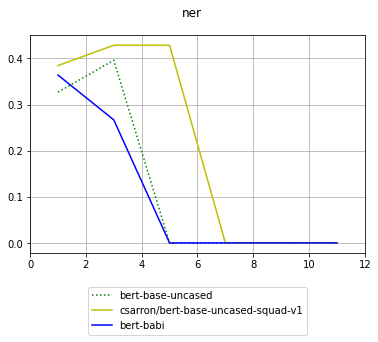

In [171]:
models = [bert_base_model, bert_squad_model, bert_babi_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], ner_results)
plt.show()

## **1.2 SEMEVAL (aka REL) Task**

In [178]:
semeval_results = {}
task = "semeval"
dataset_size = "small"

### 1.2.1 Train `bert-base` model

In [ ]:
# Probe SEMEVAL task with bert-base and bert-squad and plot macro f1 score
bert_base_model = "bert-base-uncased"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

semeval_results[bert_base_model] = {}
semeval_results[bert_base_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(bert_base_model, task, n_layers, dataset_size) # get f1_macro after probing
    semeval_results[bert_base_model][task][n_layers] = {}
    semeval_results[bert_base_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [179]:
semeval_results[bert_base_model] = {
      'semeval': {
          1: {'f1_macro': '0.021052631578947368'}, 
          3: {'f1_macro': '0.0'}, 
          5: {'f1_macro': '0.0'}, 
          7: {'f1_macro': '0.0'}, 
          9: {'f1_macro': '0.0'}, 
          11: {'f1_macro': '0.0'}
        }
      }

### 1.2.2 Train `bert-base-finetuned-squad` model

In [ ]:
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
num_layers = list(range(7, 13, 2))      # from 1 to 12 layers 

semeval_results[bert_squad_model] = {}
semeval_results[bert_squad_model][task] = {}
for n_layers in num_layers:
    f1_macro = probe(bert_squad_model, task, n_layers, dataset_size) # get f1_macro after probing
    semeval_results[bert_squad_model][task][n_layers] = {}
    semeval_results[bert_squad_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [180]:
semeval_results[bert_squad_model] = {
      'semeval': {
          1: {'f1_macro': '0.17449392712550607'}, 
          3: {'f1_macro': '0.0'}, 
          5: {'f1_macro': '0.0'}, 
          7: {'f1_macro': '0.0'}, 
          9: {'f1_macro': '0.0'}, 
          11: {'f1_macro': '0.0'}
        }
      }

### 1.2.3 Train `bert-base-finetuned-babi` model

In [ ]:
bert_babi_model = "bert-babi"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

semeval_results[bert_babi_model] = {}
semeval_results[bert_babi_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, bert_babi_model, n_layers, bin_model_path=babi_model_path)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    semeval_results[bert_babi_model][task][n_layers] = {}
    semeval_results[bert_babi_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [181]:
semeval_results[bert_babi_model] = {
      'semeval': {
          1: {'f1_macro': '0.16478696741854637'}, 
          3: {'f1_macro': '0.011695906432748537'}, 
          5: {'f1_macro': '0.0'}, 
          7: {'f1_macro': '0.0'}, 
          9: {'f1_macro': '0.0'}, 
          11: {'f1_macro': '0.0'}
      }
    }

### 1.2.4 Visualization

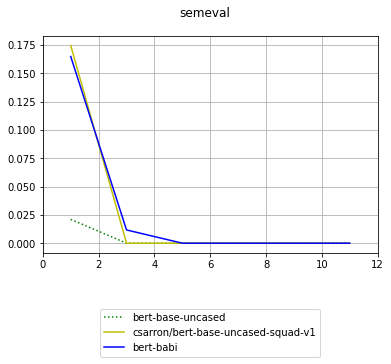

In [182]:
models = [bert_base_model, bert_squad_model, bert_babi_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], semeval_results)
plt.show()

## **1.3 COREF Task**

In [208]:
coref_results = {}
task = "coref"
dataset_size = "small"

### 1.3.1 Train `bert-base` model

In [ ]:
bert_base_model = "bert-base-uncased"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

coref_results[bert_base_model] = {}
coref_results[bert_base_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(bert_base_model, task, n_layers, dataset_size) # get f1_macro after probing
    coref_results[bert_base_model][task][n_layers] = {}
    coref_results[bert_base_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [209]:
bert_base_model = "bert-base-uncased"
coref_results[bert_base_model] = {
    'coref': {
        1: {'f1_macro': '0.7942326490713587'}, 
        3: {'f1_macro': '0.4074074074074074'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 1.3.2 Train `bert-base-finetuned-squad` model

In [ ]:
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
num_layers = list(range(5, 13, 2))      # from 1 to 12 layers 

coref_results[bert_squad_model] = {}
coref_results[bert_squad_model][task] = {}
for n_layers in num_layers:
    f1_macro = probe(bert_squad_model, task, n_layers, dataset_size) # get f1_macro after probing
    coref_results[bert_squad_model][task][n_layers] = {}
    coref_results[bert_squad_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [210]:
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
coref_results[bert_squad_model] = {
    'coref': {
        1: {'f1_macro': '0.7834101382488479'}, 
        3: {'f1_macro': '0.3928571428571429'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.3928571428571429'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 1.3.3 Train `bert-base-finetuned-babi` model

In [ ]:
bert_babi_model = "bert-babi"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

coref_results[bert_babi_model] = {}
coref_results[bert_babi_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, bert_babi_model, n_layers, bin_model_path=babi_model_path)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    coref_results[bert_babi_model][task][n_layers] = {}
    coref_results[bert_babi_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [211]:
bert_babi_model = "bert-babi"
coref_results[bert_babi_model] = {
    'coref': {
        1: {'f1_macro': '0.746031746031746'}, 
        3: {'f1_macro': '0.45022194039315155'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 1.3.4 Visualization

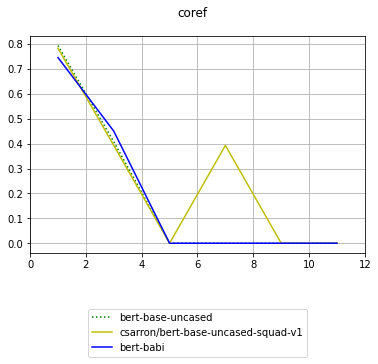

In [191]:
models = [bert_base_model, bert_squad_model, bert_babi_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], coref_results)
plt.show()

## **1.4 QUES Task**

In [197]:
ques_results = {}
task = "ques"
dataset_size = "small"

### 1.4.1 Train `bert-base` model

In [ ]:
bert_base_model = "bert-base-uncased"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ques_results[bert_base_model] = {}
ques_results[bert_base_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(bert_base_model, task, n_layers, dataset_size) # get f1_macro after probing
    ques_results[bert_base_model][task][n_layers] = {}
    ques_results[bert_base_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [198]:
bert_base_model = "bert-base-uncased"
ques_results[bert_base_model] = {
    'ques': {
        1: {'f1_macro': '0.0833234303822539'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 1.4.2 Train `bert-base-finetuned-squad` model

In [ ]:
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ques_results[bert_squad_model] = {}
ques_results[bert_squad_model][task] = {}
for n_layers in num_layers:
    f1_macro = probe(bert_squad_model, task, n_layers, dataset_size) # get f1_macro after probing
    ques_results[bert_squad_model][task][n_layers] = {}
    ques_results[bert_squad_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [199]:
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
ques_results[bert_squad_model] = {
    'ques': {
        1: {'f1_macro': '0.0404040404040404'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 1.4.3 Train `bert-base-finetuned-babi` model

In [ ]:
bert_babi_model = "bert-babi"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ques_results[bert_babi_model] = {}
ques_results[bert_babi_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, bert_babi_model, n_layers, bin_model_path=babi_model_path)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    ques_results[bert_babi_model][task][n_layers] = {}
    ques_results[bert_babi_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [200]:
bert_babi_model = "bert-babi"
ques_results[bert_babi_model] = {
    'ques': {
        1: {'f1_macro': '0.0665478312537136'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 1.4.4 Visualization

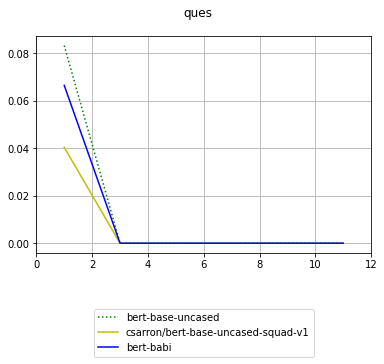

In [201]:
models = [bert_base_model, bert_squad_model, bert_babi_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], ques_results)
plt.show()

## **1.5 SUP-SQUAD Task**

In [214]:
sup_squad_results = {}
task = "sup-squad"
dataset_size = "test"

### 1.5.1 Train `bert-base` model

In [ ]:
bert_base_model = "bert-base-uncased"
num_layers = list(range(9, 13, 2))      # from 1 to 12 layers 

sup_squad_results[bert_base_model] = {}
sup_squad_results[bert_base_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(bert_base_model, task, n_layers, dataset_size) # get f1_macro after probing
    sup_squad_results[bert_base_model][task][n_layers] = {}
    sup_squad_results[bert_base_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [215]:
bert_base_model = "bert-base-uncased"
sup_squad_results[bert_base_model] = {
    'sup-squad': {
        1: {'f1_macro': '0.3846153846153846'}, 
        3: {'f1_macro': '0.3333333333333333'}, 
        5: {'f1_macro': '0.42857142857142855'}, 
        7: {'f1_macro': '0.42857142857142855'}, 
        9: {'f1_macro': '0.42857142857142855'}, 
        11: {'f1_macro': '0.42857142857142855'}
      }
    }

### 1.5.2 Train `bert-base-finetuned-squad` model

In [ ]:
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

sup_squad_results[bert_squad_model] = {}
sup_squad_results[bert_squad_model][task] = {}
for n_layers in num_layers:
    f1_macro = probe(bert_squad_model, task, n_layers, dataset_size) # get f1_macro after probing
    sup_squad_results[bert_squad_model][task][n_layers] = {}
    sup_squad_results[bert_squad_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [216]:
bert_squad_model = "csarron/bert-base-uncased-squad-v1"
sup_squad_results[bert_squad_model] = {
    'sup-squad': {
        1: {'f1_macro': '0.3846153846153846'}, 
        3: {'f1_macro': '0.42857142857142855'}, 
        5: {'f1_macro': '0.42857142857142855'}, 
        7: {'f1_macro': '0.42857142857142855'}, 
        9: {'f1_macro': '0.42857142857142855'}, 
        11: {'f1_macro': '0.42857142857142855'}
      }
    }

### 1.5.3 Visualization

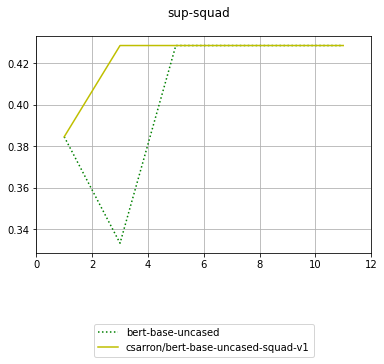

In [217]:
models = [bert_base_model, bert_squad_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], sup_squad_results)
plt.show()

## **1.6 SUP-BABI Task**

In [220]:
sup_babi_results = {}
task = "sup-babi"
dataset_size = "test"

### 1.6.1 Train `bert-base` model

In [ ]:
bert_base_model = "bert-base-uncased"
num_layers = list(range(11, 13, 2))      # from 1 to 12 layers 

sup_babi_results[bert_base_model] = {}
sup_babi_results[bert_base_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(bert_base_model, task, n_layers, dataset_size) # get f1_macro after probing
    sup_babi_results[bert_base_model][task][n_layers] = {}
    sup_babi_results[bert_base_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [221]:
bert_base_model = "bert-base-uncased"
sup_babi_results[bert_base_model] = {
    'sup-babi': {
        1: {'f1_macro': '0.7700578990901572'}, 
        3: {'f1_macro': '0.47058823529411764'}, 
        5: {'f1_macro': '0.47058823529411764'}, 
        7: {'f1_macro': '0.47058823529411764'}, 
        9: {'f1_macro': '0.47058823529411764'}, 
        11: {'f1_macro': '0.47058823529411764'}
      }
    }

### 1.6.2 Train `bert-base-finetuned-babi` model

In [ ]:
bert_babi_model = "bert-babi"
num_layers = list(range(11, 13, 2))      # from 1 to 12 layers 

sup_babi_results[bert_babi_model] = {}
sup_babi_results[bert_babi_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, bert_babi_model, n_layers, bin_model_path=babi_model_path)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    sup_babi_results[bert_babi_model][task][n_layers] = {}
    sup_babi_results[bert_babi_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting


In [222]:
bert_babi_model = "bert-babi"
sup_babi_results[bert_babi_model] = {
    'sup-babi': {
        1: {'f1_macro': '0.6228571428571429'}, 
        3: {'f1_macro': '0.47058823529411764'}, 
        5: {'f1_macro': '0.47058823529411764'}, 
        7: {'f1_macro': '0.47058823529411764'}, 
        9: {'f1_macro': '0.47058823529411764'}, 
        11: {'f1_macro': '0.47058823529411764'}
      }
    }

### 1.6.3 Visualization

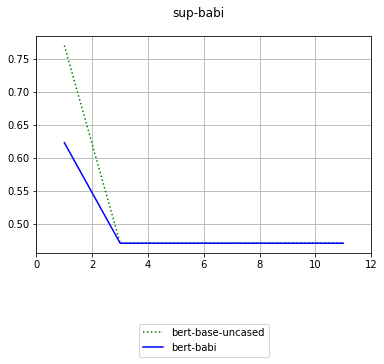

In [223]:
models = [bert_base_model, bert_babi_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], sup_babi_results)
plt.show()

# **2. Experiment with `Bert-base-uncased` trained on `AdversarialQA` dataset**

---



##**2.0 Download and export Bert finetuned Adversarial dataset model**

In [ ]:
import os

bert_adversarial_model = "bert-adversarial"
bert_adversarial_path = "/content/bert-adversarial"
os.makedirs(bert_adversarial_path, exist_ok=True)

# google drive id of all files included in bert-base-adversarial
config_json_id = "19-gobmJ_8PWuQURkHZ1JvEtublNS29Cd"
pytorch_model_bin_id = "1G8WurpHMyfk14nHgaZ9b6CKPCi3HdbQc"
special_tokens_map_id = "1GZI4j31ejNFYlEJfgW70bs1cV6He_LEX"
tokenizer_config_id = "1qhSB_QoGL1Kel_2OwAXHP5uTCkPAW4Pl"
tokenizer_json_id = "1wWRk5BdPBwGUd6X3halFrDWq_KqPCVe3"
training_args_id = "1bHZqsV08OjsN6n4Gax1luwF5Rcn4e3AG"
vocab_id = "1aAYV6W5isBQe2T09QbkAkYGibyEsXDyE"

!gdown --id "{config_json_id}" -O "{bert_adversarial_path}/config.json"
!gdown --id "{pytorch_model_bin_id}" -O "{bert_adversarial_path}/pytorch_model.bin"
!gdown --id "{special_tokens_map_id}" -O "{bert_adversarial_path}/special_tokens_map.json"
!gdown --id "{tokenizer_config_id}" -O "{bert_adversarial_path}/tokenizer_config.json"
!gdown --id "{tokenizer_json_id}" -O "{bert_adversarial_path}/tokenizer.json"
!gdown --id "{training_args_id}" -O "{bert_adversarial_path}/training_args.bin"
!gdown --id "{vocab_id}" -O "{bert_adversarial_path}/vocab.txt"

In [ ]:
export_model.export_model(
    hf_pretrained_model_name_or_path=bert_adversarial_path,
    output_base_path=f"/content/models/{bert_adversarial_model}",
)

## **2.1 NER Task**

### 2.1.1 Train

In [ ]:
task = "ner"
dataset_size = "small"
ner_results = {}

bert_adversarial_model = "bert-adversarial"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ner_results[bert_adversarial_model] = {}
ner_results[bert_adversarial_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)

    run_args = main_runscript.RunConfiguration(
        jiant_task_container_config_path=f"/content/tasks/run_configs/{task}_run_config.json",
        output_dir=f"/content/tasks/runs/{task}",
        hf_pretrained_model_name_or_path=bert_adversarial_path,
        model_path=f"/content/models/{bert_adversarial_model}/model/model.p",
        model_config_path=f"/content/models/{bert_adversarial_model}/model/config.json",
        learning_rate=1e-3,
        eval_every_steps=1000,
        do_train=True,
        do_val=True,
        do_save=True,
        force_overwrite=True,
        num_hidden_layers=n_layers,
    )
    probing_output = main_runscript.run_loop(run_args)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    ner_results[bert_adversarial_model][task][n_layers] = {}
    ner_results[bert_adversarial_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [172]:
bert_adversarial_model = "bert-adversarial"
ner_results[bert_adversarial_model] = {
    'ner': {
        1: {'f1_macro': '0.10784313725490197'}, 
        3: {'f1_macro': '0.0971861471861472'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.14662822557559402'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 2.1.2 Visualization

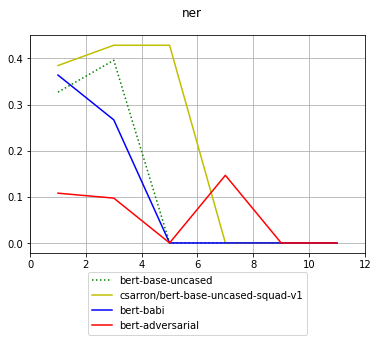

In [173]:
models = [bert_base_model, bert_squad_model, bert_babi_model, bert_adversarial_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], ner_results)
plt.show()

## **2.2 SEMEVAL Task**

### 2.2.1 Train

In [ ]:
task = "semeval"
dataset_size = "small"

bert_adversarial_model = "bert-adversarial"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

semeval_results[bert_adversarial_model] = {}
semeval_results[bert_adversarial_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)

    run_args = main_runscript.RunConfiguration(
        jiant_task_container_config_path=f"/content/tasks/run_configs/{task}_run_config.json",
        output_dir=f"/content/tasks/runs/{task}",
        hf_pretrained_model_name_or_path=bert_adversarial_path,
        model_path=f"/content/models/{bert_adversarial_model}/model/model.p",
        model_config_path=f"/content/models/{bert_adversarial_model}/model/config.json",
        learning_rate=1e-3,
        eval_every_steps=1000,
        do_train=True,
        do_val=True,
        do_save=True,
        force_overwrite=True,
        num_hidden_layers=n_layers,
    )
    probing_output = main_runscript.run_loop(run_args)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    semeval_results[bert_adversarial_model][task][n_layers] = {}
    semeval_results[bert_adversarial_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [183]:
bert_adversarial_model = "bert-adversarial"
semeval_results[bert_adversarial_model] = {
    'semeval': {
        1: {'f1_macro': '0.07832080200501253'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 2.2.2 Visualization

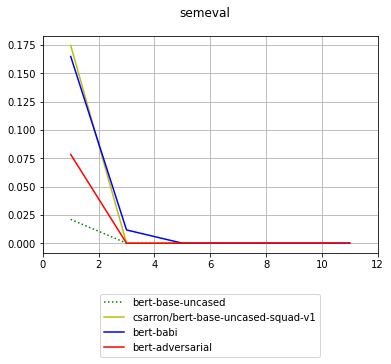

In [184]:
models = [bert_base_model, bert_squad_model, bert_babi_model, bert_adversarial_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], semeval_results)
plt.show()

## **2.3 COREF Task**

### 2.3.1 Train

In [ ]:
task = "coref"
dataset_size = "small"

bert_adversarial_model = "bert-adversarial"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

coref_results[bert_adversarial_model] = {}
coref_results[bert_adversarial_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)

    run_args = main_runscript.RunConfiguration(
        jiant_task_container_config_path=f"/content/tasks/run_configs/{task}_run_config.json",
        output_dir=f"/content/tasks/runs/{task}",
        hf_pretrained_model_name_or_path=bert_adversarial_path,
        model_path=f"/content/models/{bert_adversarial_model}/model/model.p",
        model_config_path=f"/content/models/{bert_adversarial_model}/model/config.json",
        learning_rate=1e-3,
        eval_every_steps=1000,
        do_train=True,
        do_val=True,
        do_save=True,
        force_overwrite=True,
        num_hidden_layers=n_layers,
    )
    probing_output = main_runscript.run_loop(run_args)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    coref_results[bert_adversarial_model][task][n_layers] = {}
    coref_results[bert_adversarial_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [212]:
bert_adversarial_model = "bert-adversarial"
coref_results[bert_adversarial_model] = {
    'coref': {
        1: {'f1_macro': '0.5064102564102564'}, 
        3: {'f1_macro': '0.37499999999999994'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

### 2.3.2 Visualization

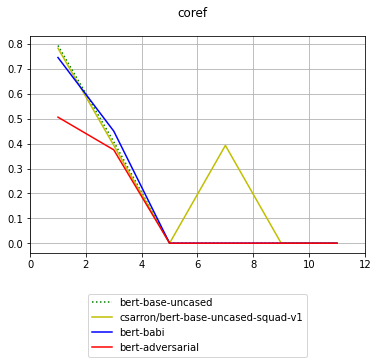

In [213]:
models = [bert_base_model, bert_squad_model, bert_babi_model, bert_adversarial_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], coref_results)
plt.show()

## **2.4 QUES Task**

###2.4.1 Train

In [ ]:
task = "ques"
dataset_size = "small"
ques_results = {}

bert_adversarial_model = "bert-adversarial"
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ques_results[bert_adversarial_model] = {}
ques_results[bert_adversarial_model][task] = {}

for n_layers in num_layers:
    init_task_config(task, dataset_size)
    tokenize(task, "bert-base-uncased")  # use tokenizer of bert base
    create_jiant_task_config(task)

    run_args = main_runscript.RunConfiguration(
        jiant_task_container_config_path=f"/content/tasks/run_configs/{task}_run_config.json",
        output_dir=f"/content/tasks/runs/{task}",
        hf_pretrained_model_name_or_path=bert_adversarial_path,
        model_path=f"/content/models/{bert_adversarial_model}/model/model.p",
        model_config_path=f"/content/models/{bert_adversarial_model}/model/config.json",
        learning_rate=1e-3,
        eval_every_steps=1000,
        do_train=True,
        do_val=True,
        do_save=True,
        force_overwrite=True,
        num_hidden_layers=n_layers,
    )
    probing_output = main_runscript.run_loop(run_args)
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])

    ques_results[bert_adversarial_model][task][n_layers] = {}
    ques_results[bert_adversarial_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [204]:
bert_adversarial_model = "bert-adversarial"
ques_results[bert_adversarial_model] = {
    'ques': {
        1: {'f1_macro': '0.0'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

###2.4.2 Visualization

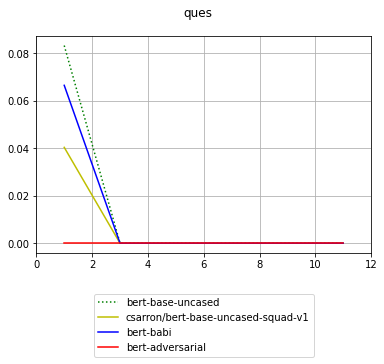

In [205]:
models = [bert_base_model, bert_squad_model, bert_babi_model, bert_adversarial_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], ques_results)
plt.show()

# **3. Experiment with `Roberta-base`**

---



Download and export Roberta-base model

In [84]:
import jiant.proj.main.export_model as export_model

roberta_model = "roberta-base"

export_model.export_model(
    hf_pretrained_model_name_or_path=roberta_model,
    output_base_path=f"/content/models/{roberta_model}",
)

## **3.1 NER Task**

###3.1.1 Train

In [ ]:
task = "ner"
dataset_size = "small"
ner_results = {}

In [ ]:
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ner_results[roberta_model] = {}
ner_results[roberta_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(roberta_model, task, n_layers, dataset_size) # get f1_macro after probing
    ner_results[roberta_model][task][n_layers] = {}
    ner_results[roberta_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [174]:
roberta_model = "roberta-base"
ner_results[roberta_model] = {
    'ner': {
        1: {'f1_macro': '0.08040177260694373'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

###3.1.2 Visualization

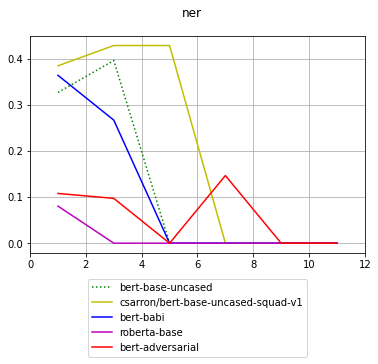

In [177]:
models = [bert_base_model, bert_squad_model, bert_babi_model, roberta_model, bert_adversarial_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], ner_results)
plt.show()

## **3.2 SEMEVAL Task**

###3.2.1 Train

In [ ]:
task = "semeval"
dataset_size = "small"

In [ ]:
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

semeval_results[roberta_model] = {}
semeval_results[roberta_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(roberta_model, task, n_layers, dataset_size) # get f1_macro after probing
    semeval_results[roberta_model][task][n_layers] = {}
    semeval_results[roberta_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [185]:
roberta_model = "roberta-base"
semeval_results[roberta_model] = {
    'semeval': {
        1: {'f1_macro': '0.0'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

###3.2.2 Visualization

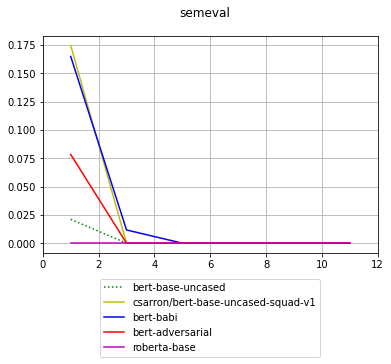

In [186]:
models = [bert_base_model, bert_squad_model, bert_babi_model, bert_adversarial_model, roberta_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], semeval_results)
plt.show()

## **3.3 COREF Task**

###3.3.1 Train

In [ ]:
task = "coref"
dataset_size = "small"

In [ ]:
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

coref_results[roberta_model] = {}
coref_results[roberta_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(roberta_model, task, n_layers, dataset_size) # get f1_macro after probing
    coref_results[roberta_model][task][n_layers] = {}
    coref_results[roberta_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [194]:
roberta_model = "roberta-base"
coref_results[roberta_model] = {
    'coref': {
        1: {'f1_macro': '0.5810381355932204'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.44525547445255476'}, 
        7: {'f1_macro': '0.44525547445255476'}, 
        9: {'f1_macro': '0.44525547445255476'}, 
        11: {'f1_macro': '0.3777777777777777'}
      }
    }

###3.3.2 Visualization

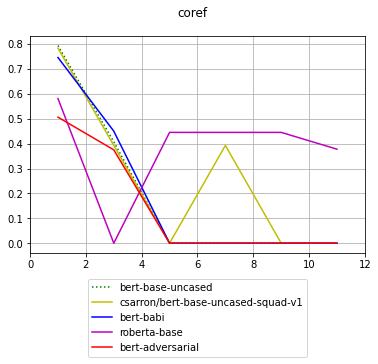

In [195]:
models = [bert_base_model, bert_squad_model, bert_babi_model, roberta_model, bert_adversarial_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], coref_results)
plt.show()

## **3.4 QUES Task**

###3.4.1 Train

In [ ]:
task = "ques"
dataset_size = "small"

In [ ]:
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

ques_results[roberta_model] = {}
ques_results[roberta_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(roberta_model, task, n_layers, dataset_size) # get f1_macro after probing
    ques_results[roberta_model][task][n_layers] = {}
    ques_results[roberta_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [206]:
roberta_model = "roberta-base"
ques_results[roberta_model] = {
    'ques': {
        1: {'f1_macro': '0.0'}, 
        3: {'f1_macro': '0.0'}, 
        5: {'f1_macro': '0.0'}, 
        7: {'f1_macro': '0.0'}, 
        9: {'f1_macro': '0.0'}, 
        11: {'f1_macro': '0.0'}
      }
    }

###3.4.2 Visualization

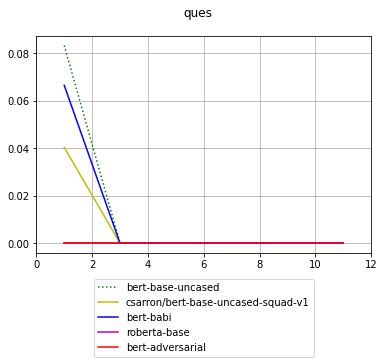

In [207]:
models = [bert_base_model, bert_squad_model, bert_babi_model, roberta_model, bert_adversarial_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], ques_results)
plt.show()

## **3.5 SUP-SQUAD Task**

###3.5.1 Train

In [ ]:
task = "sup-squad"
dataset_size = "small"

In [ ]:
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

sup_squad_results[roberta_model] = {}
sup_squad_results[roberta_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(roberta_model, task, n_layers, dataset_size) # get f1_macro after probing
    sup_squad_results[roberta_model][task][n_layers] = {}
    sup_squad_results[roberta_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [218]:
roberta_model = "roberta-base"
sup_squad_results[roberta_model] = {
    'sup-squad': {
        1: {'f1_macro': '0.5017421602787456'}, 
        3: {'f1_macro': '0.44525547445255476'}, 
        5: {'f1_macro': '0.44525547445255476'}, 
        7: {'f1_macro': '0.44525547445255476'}, 
        9: {'f1_macro': '0.44525547445255476'}, 
        11: {'f1_macro': '0.44525547445255476'}
      }
    }

###3.5.2 Visualization

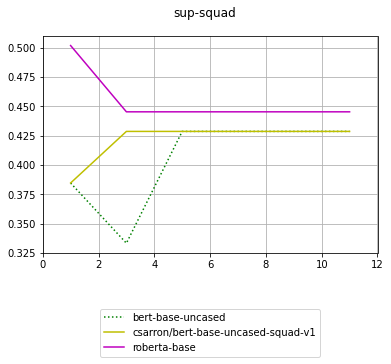

In [219]:
models = [bert_base_model, bert_squad_model, roberta_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], sup_squad_results)
plt.show()

## **3.6 SUP-BABI Task**

###3.6.1 Train

In [82]:
task = "sup-babi"
dataset_size = "test"

In [ ]:
num_layers = list(range(1, 13, 2))      # from 1 to 12 layers 

sup_babi_results[roberta_model] = {}
sup_babi_results[roberta_model][task] = {}

for n_layers in num_layers:
    f1_macro = probe(roberta_model, task, n_layers, dataset_size) # get f1_macro after probing
    sup_babi_results[roberta_model][task][n_layers] = {}
    sup_babi_results[roberta_model][task][n_layers]['f1_macro'] = f1_macro # save f1 macro for plotting

In [224]:
roberta_model = "roberta-base"
sup_babi_results[roberta_model] = {
    'sup-babi': {
        1: {'f1_macro': '0.4666666666666667'}, 
        3: {'f1_macro': '0.4666666666666667'}, 
        5: {'f1_macro': '0.4666666666666667'}, 
        7: {'f1_macro': '0.4666666666666667'}, 
        9: {'f1_macro': '0.4666666666666667'}, 
        11: {'f1_macro': '0.4666666666666667'}
      }
    }

###3.6.2 Visualization

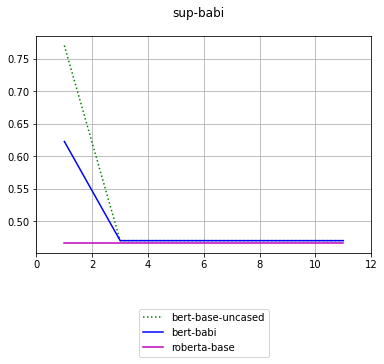

In [225]:
models = [bert_base_model, bert_babi_model, roberta_model]

for model in models:
  plot_task(model, task, model_to_linestyle[model], sup_babi_results)
plt.show()